In [588]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

from itertools import product
from tqdm import tqdm


from more_itertools import unique_everseen
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer

from datetime import datetime, date

In [589]:
data = pd.read_csv('data.csv', encoding = "cp1251",  sep=';')

**Part 1**

In [590]:
stemmer = RussianStemmer()
stop = stopwords.words('russian')
stop.extend(['г', 'г.'])

stop.remove('по')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/nltk/corpus/reader/wordlist.py:28: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/bahruzjafarov/nltk_data/corpora/stopwords/russian'>
  return concat([self.open(f).read() for f in fileids])


In [591]:

def replaceMonth(line):
    month1 = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль',
                 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']
    month2 = ['января', 'февраля', 'марта', 'апреля', 'мая', 'июня', 'июля',
                 'августа', 'сентября', 'октября', 'ноября', 'декабря']
    for i,j in zip(month1, month2):
        line = line.replace(' '+i+' ','.'+str(month1.index(i)+1)+'.')
        line = line.replace(' '+i,'.'+str(month1.index(i)+1)+'.')
        line = line.replace(' '+j+' ','.'+str(month2.index(j)+1)+'.')
        line = line.replace(' '+j,'.'+str(month2.index(j)+1)+'.')
    return line
    
def isReversedDate(time):
    '''If date format is YYYY(YY)/MM/DD'''
    if int(time[2])<=31 and int(time[1])<=12 and (int(time[0])<=18 or (int(time[0])>=2000 and int(time[0])<=2018)):
        return True
    else:
        False

def isDate(line):
    if len(line)>2:
        if line[-1] == '.':
            line = line[:-1]
        line = line.split('г')[0]
        if 'т' in line:
            line = line.split('т')[1]
            
        if line.count('.')==2:
            time = line.split('.')
            if time[0].isdigit() and time[1].isdigit() and time[2].isdigit():
                if int(time[0])<=31 and int(time[1])<=12 and (int(time[2])<=18 or (int(time[2])>=2000 and int(time[2])<=2018)):
                    return time[0]+'.'+time[1]+'.'+time[2]
                elif isReversedDate(time):
                    return time[2]+'.'+time[1]+'.'+time[0]
                else:
                    return False 
            else:
                return False
            
    else:
        return False
    
def isEvent(line):
    global prepayment
    if line == 'предоплат':
        prepayment = True 
        return False
    elif line == 'дого':
        return 'ПоДоговоруОтДаты'
    elif line == 'счет':
        return 'ПоСчетуОтДаты'
    elif line == 'письм':
        return 'ПоПисьмуОтДаты'
    elif line == 'писк':
        return 'ПоЗапискеОтДаты'


def russianStemmer(line):
    k = []
    for i in line:
        word = stemmer.stem(i)
        if word not in stop:
            for i in ['сумм', '(', ')', 'ндс', 'за', 'по', '_', 'в', '№']: 
                word = word.replace(i, ' ')
            word = word.strip()
            for j in word.split():
                k.append(j)
    return k



def delMistakes(line):
    line = line.replace('. 2', '.2')
    line = line.replace('1 2', '12')
    line = line.replace('1 3', '13')
    line = line.replace('1 4', '14')
    line = line.replace('1 5', '15')
    line = line.replace('1 6', '16')
    line = line.replace('о к', 'ок')
    line = line.replace('.д', ' д')
    line = line.replace('д о', 'до')
    line = line.replace('c', 'с')
    line = line.replace('аперл', 'апрел')
    
    return line

def delReductions(line):
    for i in [',', '-', '?', '!', '%', ':', '/']:
        line = line.replace(i, '.')
        
    for i in ['опалат', 'опл.']:
        line = line.replace(i, 'оплата')
        
    for i in ['аванс', 'п.оплата', 'п/оплата', 'предоплатаовый']:
        line = line.replace(i, 'предоплата')
        
    for i in ['дог.', 'дог ']:
        line = line.replace(i, 'договору ')
        
    for i in ['сч.', 'сч ']:
        line = line.replace(i, 'счету ')
        
    return line

def binarySearch(eventListT, dateListT, rightSize):
    dateList = []
    eventList = []
    counterDate = 0
    counterEvent = 0
    while len(dateList)!=rightSize and len(eventList)!=rightSize:

        if counterEvent!=len(eventListT)-1 and counterDate!=len(dateListT )-1:

            if eventListT[counterEvent][1] > dateListT[counterDate][1]:
                counterDate += 1
            elif eventListT[counterEvent][1] < dateListT[counterDate][1]:
                dateList.append(dateListT[counterDate][0])
                eventList.append(eventListT[counterEvent][0]) 
                counterDate += 1
                counterEvent += 1
            else:
                print('ERROR 1')

        elif counterEvent!=len(eventListT)-1: # last element in date list

            if eventListT[counterEvent+1][1] < dateListT[counterDate][1]:
                counterEvent += 1
            elif eventListT[counterEvent][1] < dateListT[counterDate][1]:
                dateList.append(dateListT[counterDate][0])
                eventList.append(eventListT[counterEvent][0]) 
                counterDate += 1
                counterEvent += 1
            else:
                print('ERROR 2')

        elif counterDate!=len(dateListT )-1: # last element in event list

            if eventListT[counterEvent][1] > dateListT[counterDate][1]:
                counterDate += 1
            elif eventListT[counterEvent][1] < dateListT[counterDate][1]:
                dateList.append(dateListT[counterDate][0])
                eventList.append(eventListT[counterEvent][0]) 
                counterDate += 1
                counterEvent += 1
            else:
                print('ERROR 3')
        elif counterEvent == len(eventListT)-1 and counterDate == len(dateListT )-1: # last elements in both lists
            dateList.append(dateListT[counterDate][0])
            eventList.append(eventListT[counterEvent][0]) 
        else:
            print('ERROR 4')
            
    return  eventList, dateList


def preprocessing(line):
    global start, finish, zz
    
    line = line.lower()
    line = line.replace('  ', ' ')
    
    
    
    line = delMistakes(line)
    line = replaceMonth(line)
    line = delReductions(line)
    line = russianStemmer(line.split())
    
    for index, word in enumerate(line): #for ДатаНачалаПериодаПоставки and ДатаОкончанияПериодаПоставки 
        try:
            if word == 'период' and line[index+1].isdigit():
                line[index+1] = line[index+1]+'.'+'.'.join(line[index+2].split('.')[1:])
                start = isDate(line[index+1])
                finish = isDate(line[index+2])
            elif isDate(line[index]) and isDate(line[index+1]):
                start = isDate(line[index])
                finish = isDate(line[index+1])
        except IndexError:
            pass
      
    dateList = []
    eventList = []
    
    for i in line:
        date = isDate(i)
        if date:
            dateList.append(date)
            
    if start and finish: # remove start/finish date of supply period from line
        dateList.remove(start)
        dateList.remove(finish)
        
    dateList = list(unique_everseen(dateList))  # remove duplicates     
        
    for i in line:
        event = isEvent(i)
        if event:
            eventList.append(event)
            
    eventList = list(unique_everseen(eventList)) # remove duplicates        
    
    if len(dateList)!=len(eventList): 
        
        rightSize = min(len(eventList), len(dateList))
        dateListT = []
        eventListT = []
        
        for index, word in enumerate(line):
            date = isDate(word)
            if date:
                dateListT.append((date,index))
            
        for index, word in enumerate(line):
            event = isEvent(word)
            if event:
                eventListT.append((event,index))
                
        eventList, dateList = binarySearch(eventListT, dateListT, rightSize)

    return eventList, dateList
                


    
start = False # start of supply period
finish = False # end of supply period

prepayment = False

def addToDataframe(row, columns, values):
    for i,j in zip(columns, values):
        row[i] = j

def changeDataframe(row):
    global start, finish, prepayment
    start, finish, prepayment = False, False, False
    eventList, dateList = preprocessing(row['НазначениеПлатежа'])
    
    if start and finish:
        addToDataframe(row, ['ДатаНачалаПериодаПоставки', 'ДатаОкончанияПериодаПоставки'], [start, finish])
    if prepayment:
        addToDataframe(row, ['Предоплата'], [1])
    if len(eventList)>0:
        addToDataframe(row, eventList, dateList)
    return row

In [592]:
for i in ['Предоплата', 'ДатаНачалаПериодаПоставки', 'ДатаОкончанияПериодаПоставки', 
          'ПоСчетуОтДаты', 'ПоДоговоруОтДаты','ПоЗапискеОтДаты','ПоПисьмуОтДаты']:
    data[i] = data[i].fillna(0)


In [593]:
data = data.apply(lambda row: changeDataframe(row), axis=1)

In [594]:
def changeDate(line):
    '''from str to datetime'''
    try:
        if line == 0 or line.split('.')[0] == '0':
            return 0
        elif len(line.split('.')[2]) == 1:
            return datetime(int('200'+line.split('.')[2]), int(line.split('.')[1]), int(line.split('.')[0]),0,0)
        elif len(line.split('.')[2]) == 2: 
            return datetime(int('20'+line.split('.')[2]), int(line.split('.')[1]), int(line.split('.')[0]),0,0)
        else: 
            return datetime(int(line.split('.')[2]), int(line.split('.')[1]), int(line.split('.')[0]),0,0)
    except:
        return 0

for i in ['ДатаНачалаПериодаПоставки', 'ДатаОкончанияПериодаПоставки', 
          'ПоСчетуОтДаты', 'ПоДоговоруОтДаты','ПоЗапискеОтДаты','ПоПисьмуОтДаты']:
    data[i] = data[i].apply(changeDate)

**Part 2**

In [595]:
def changeSum(value):
    value = value.replace(',','.')
    value = value.replace(' ','')
    if value.isdigit() or (value.split('.')[0].isdigit() == True and value.split('.')[1].isdigit() == True):
        return float(value)
    else:
        return 0

data['СуммаДокумента'] = data['СуммаДокумента'].apply(changeSum)

*ARIMA*

In [596]:
df = data[(data['СуммаДокумента']!=0)&(data['ПоСчетуОтДаты']!=0)]
df = df.groupby(['ПоСчетуОтДаты'])[['СуммаДокумента']].sum().reset_index()

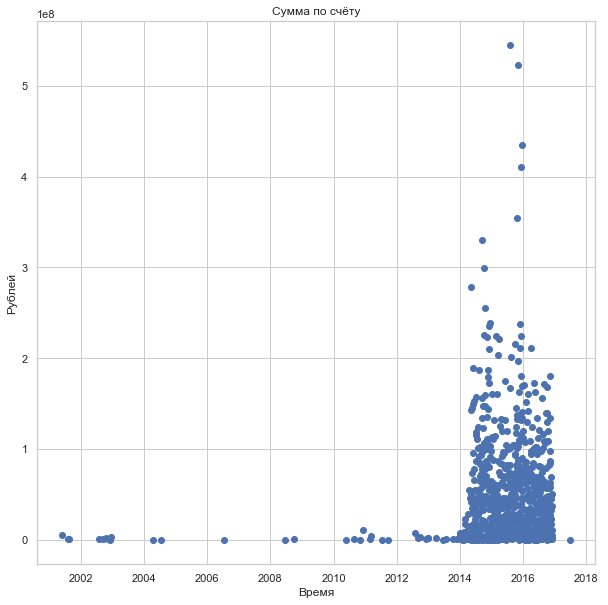

In [597]:
dates = matplotlib.dates.date2num(df['ПоСчетуОтДаты'].tolist())
plt.plot_date(dates, df['СуммаДокумента'].tolist())
plt.title('Сумма по счёту')
plt.xlabel('Время')
plt.ylabel('Рублей')
plt.grid(True)
#plt.figure(figsize=(10,5))
plt.rcParams["figure.figsize"] = (17,7)

plt.show()

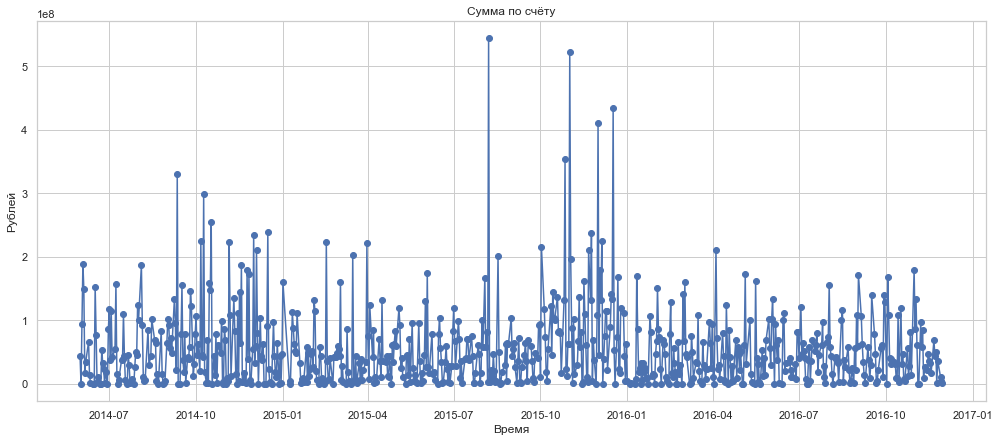

In [598]:
df = df[100:-1]

dates = matplotlib.dates.date2num(df['ПоСчетуОтДаты'].tolist())
plt.plot_date(dates, df['СуммаДокумента'].tolist(), ls = '-')
plt.title('Сумма по счёту')
plt.xlabel('Время')
plt.ylabel('Рублей')
plt.grid(True)
plt.rcParams["figure.figsize"] = (17,7)


plt.show()

In [599]:
def moving_average(series, n):
    return np.average(series[-n:])

def plotMovingAverage(series, n):
    rolling_mean = series.rolling(window=n).mean()
    plt.figure(figsize=(17,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend", c='k')
    
    plt.plot(series.tolist()[n:], label="Actual values")
    
    plt.legend(loc="upper left")
    plt.grid(True)
    
    result = adfuller(rolling_mean.values[n:])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.980515
p-value: 0.001516
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


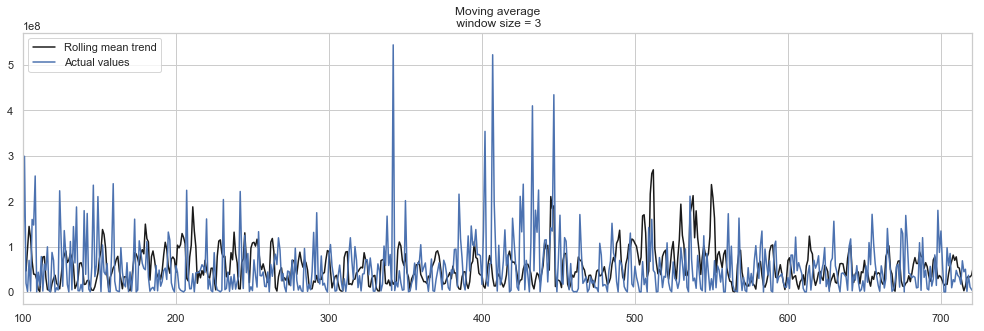

In [600]:
plotMovingAverage(df['СуммаДокумента'], 3)
plt.xlim(100, 720)
plt.show()

ADF Statistic: -2.563561
p-value: 0.100765
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


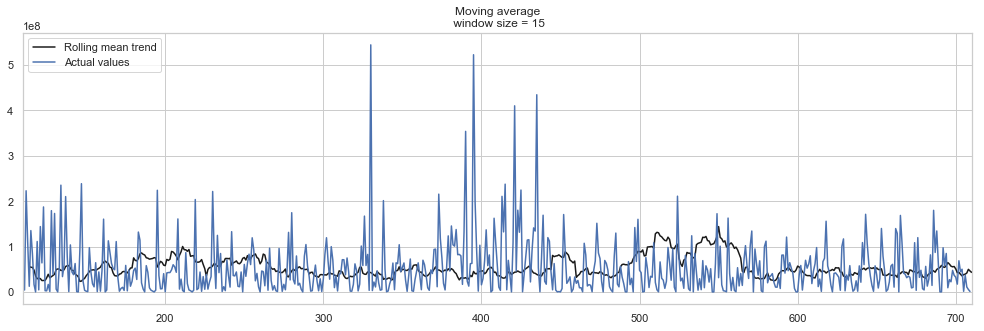

In [601]:
plotMovingAverage(df['СуммаДокумента'], 15)
plt.xlim(110, 710)
plt.show()

ADF Statistic: -2.374641
p-value: 0.149022
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


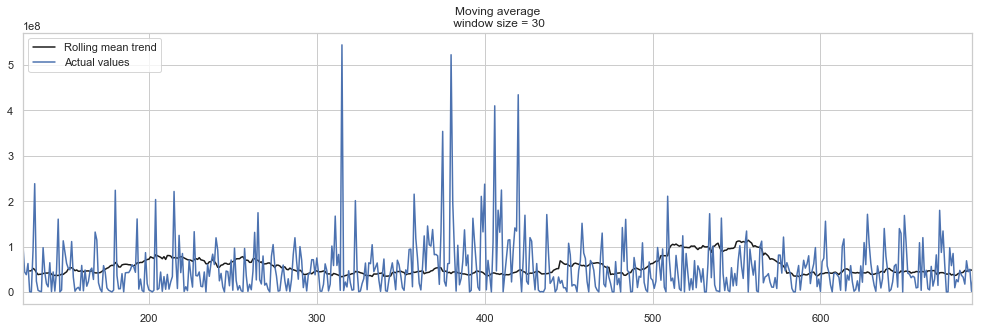

In [602]:
plotMovingAverage(df['СуммаДокумента'], 30)
plt.xlim(125, 690)
plt.show()

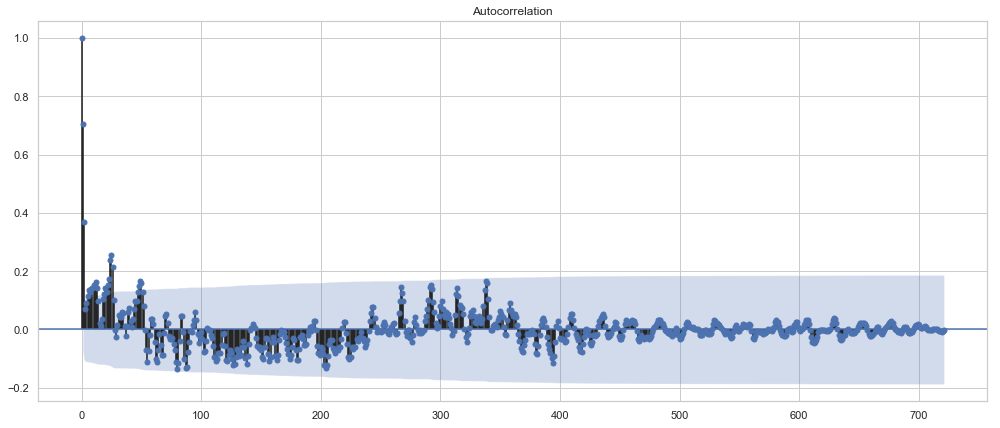

In [603]:
smt.graphics.plot_acf(df['СуммаДокумента'].rolling(window=3).mean().values[3:])
plt.show()

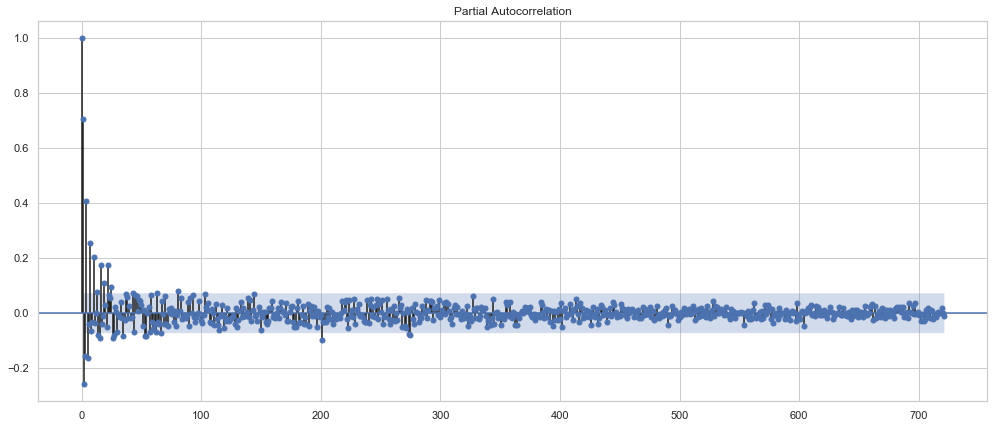

In [604]:
smt.graphics.plot_pacf(df['СуммаДокумента'].rolling(window=3).mean().values[3:])
plt.show()

In [605]:
ts = pd.DataFrame()
ts['СуммаДокумента'] = df['СуммаДокумента'].rolling(window=3).mean().values[3:]
ts['СуммаДокумента'] = ts['СуммаДокумента'] - ts['СуммаДокумента'].shift(1)

ADF Statistic: -10.524724
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


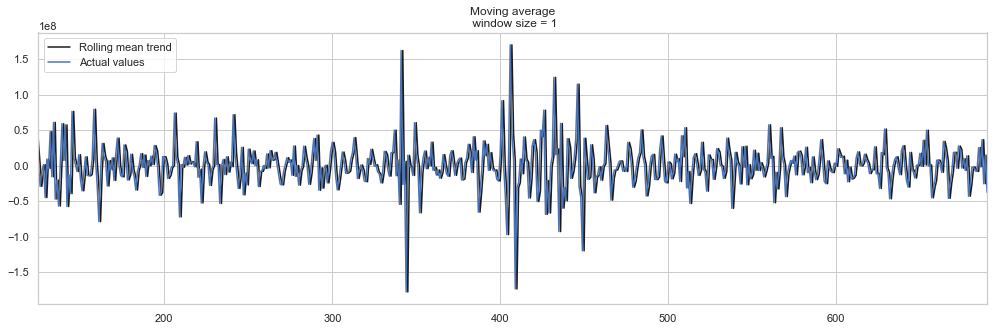

In [606]:
plotMovingAverage(ts['СуммаДокумента'], 1)
plt.xlim(125, 690)
plt.show()

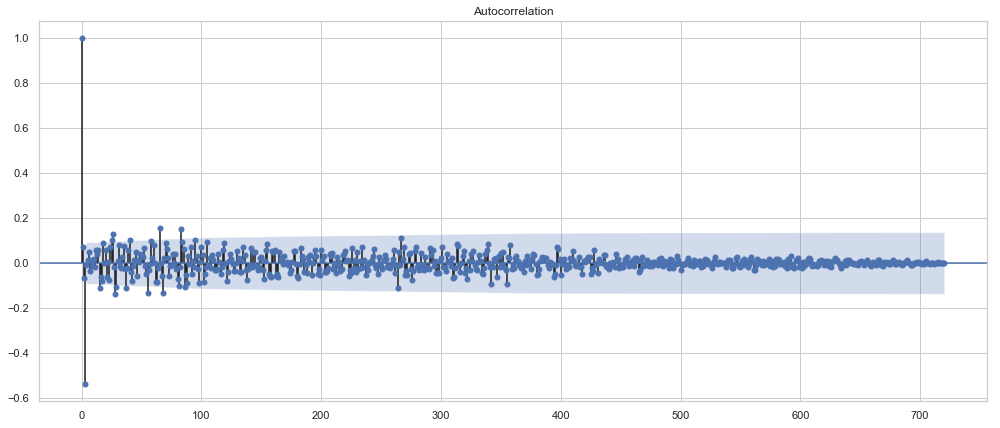

In [607]:
smt.graphics.plot_acf(ts['СуммаДокумента'].rolling(window=1).mean().values[1:])
plt.show()

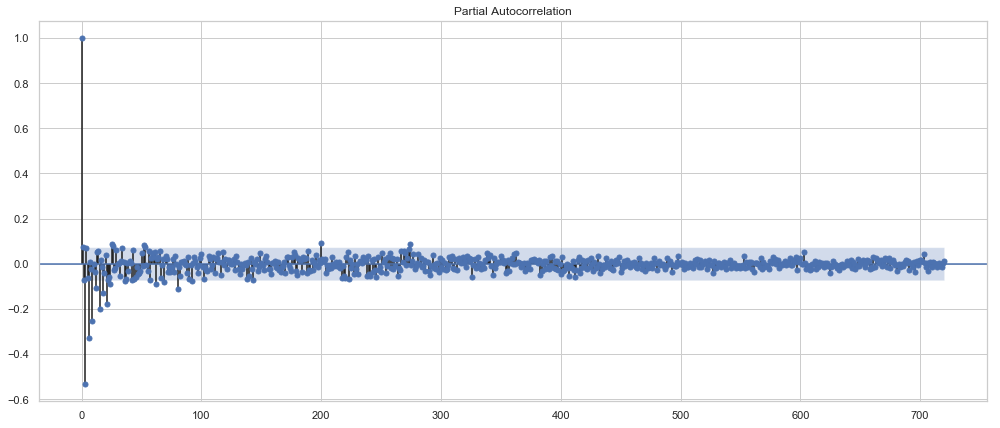

In [608]:
smt.graphics.plot_pacf(ts['СуммаДокумента'].rolling(window=1).mean().values[1:])
plt.show()

In [609]:
p = range(0, 10)
d = 1
q = range(0, 10)

parameters = product(p, q)
parameters_list = list(parameters)

results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model=statsmodels.tsa.arima_model.ARIMA(ts['СуммаДокумента'].rolling(window=1).mean().values[1:][:], order=(param[0], 1, param[1])).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  0%|          | 0/100 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequ

wrong parameters: (0, 3)
wrong parameters: (0, 4)
wrong parameters: (0, 5)
wrong parameters: (0, 6)
wrong parameters: (0, 7)
wrong parameters: (0, 8)
wrong parameters: (0, 9)


 14%|█▍        | 14/100 [00:00<00:10,  8.46it/s]

wrong parameters: (1, 3)
wrong parameters: (1, 4)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 20%|██        | 20/100 [00:05<00:36,  2.18it/s]

wrong parameters: (1, 7)
wrong parameters: (1, 8)
wrong parameters: (1, 9)


 25%|██▌       | 25/100 [00:05<00:16,  4.46it/s]

wrong parameters: (2, 2)
wrong parameters: (2, 3)
wrong parameters: (2, 4)


 29%|██▉       | 29/100 [00:11<00:51,  1.38it/s]

wrong parameters: (2, 7)
wrong parameters: (2, 8)
wrong parameters: (2, 9)


 36%|███▌      | 36/100 [00:12<00:23,  2.78it/s]

wrong parameters: (3, 3)
wrong parameters: (3, 4)
wrong parameters: (3, 5)
wrong parameters: (3, 6)


 38%|███▊      | 38/100 [00:12<00:17,  3.60it/s]

wrong parameters: (3, 7)


 41%|████      | 41/100 [00:19<00:51,  1.14it/s]

wrong parameters: (3, 9)


 46%|████▌     | 46/100 [00:21<00:29,  1.83it/s]

wrong parameters: (4, 3)
wrong parameters: (4, 4)
wrong parameters: (4, 5)
wrong parameters: (4, 6)
wrong parameters: (4, 7)


 55%|█████▌    | 55/100 [00:38<00:53,  1.19s/it]

wrong parameters: (5, 3)
wrong parameters: (5, 4)


 58%|█████▊    | 58/100 [00:39<00:26,  1.60it/s]

wrong parameters: (5, 5)
wrong parameters: (5, 6)
wrong parameters: (5, 7)
wrong parameters: (5, 8)


 68%|██████▊   | 68/100 [00:57<00:25,  1.26it/s]

wrong parameters: (6, 3)
wrong parameters: (6, 4)
wrong parameters: (6, 5)
wrong parameters: (6, 6)
wrong parameters: (6, 7)


 70%|███████   | 70/100 [00:57<00:17,  1.72it/s]

wrong parameters: (6, 8)
wrong parameters: (6, 9)


 76%|███████▌  | 76/100 [01:01<00:18,  1.33it/s]

wrong parameters: (7, 3)
wrong parameters: (7, 4)
wrong parameters: (7, 5)
wrong parameters: (7, 6)
wrong parameters: (7, 7)


 79%|███████▉  | 79/100 [01:01<00:11,  1.85it/s]

wrong parameters: (7, 8)
wrong parameters: (7, 9)


 86%|████████▌ | 86/100 [01:06<00:09,  1.53it/s]

wrong parameters: (8, 3)
wrong parameters: (8, 4)
wrong parameters: (8, 5)
wrong parameters: (8, 6)
wrong parameters: (8, 7)


 89%|████████▉ | 89/100 [01:06<00:05,  2.12it/s]

wrong parameters: (8, 8)
wrong parameters: (8, 9)


100%|██████████| 100/100 [01:38<00:00,  1.01it/s]

wrong parameters: (9, 6)
wrong parameters: (9, 7)
wrong parameters: (9, 8)
wrong parameters: (9, 9)
   parameters           aic
10     (2, 5)  26373.454808
11     (2, 6)  26378.693798
19     (4, 8)  26380.474667
6      (1, 5)  26383.033601
15     (3, 8)  26384.575030


In [610]:
best_model = statsmodels.tsa.arima_model.ARIMA(ts['СуммаДокумента'].rolling(window=1).mean().values[1:][:], order=(4, 1, 8)).fit(disp=-1)
print(best_model.summary())   

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pack

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  720
Model:                 ARIMA(4, 1, 8)   Log Likelihood              -13176.237
Method:                       css-mle   S.D. of innovations       21194027.049
Date:                Mon, 24 Sep 2018   AIC                          26380.475
Time:                        19:24:49   BIC                          26444.584
Sample:                             1   HQIC                         26405.224
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.559e+04        nan        nan        nan         nan         nan
ar.L1.D.y     -0.1902      0.039     -4.933      0.000      -0.266      -0.115
ar.L2.D.y      0.4374      0.045      9.746      0.0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pack

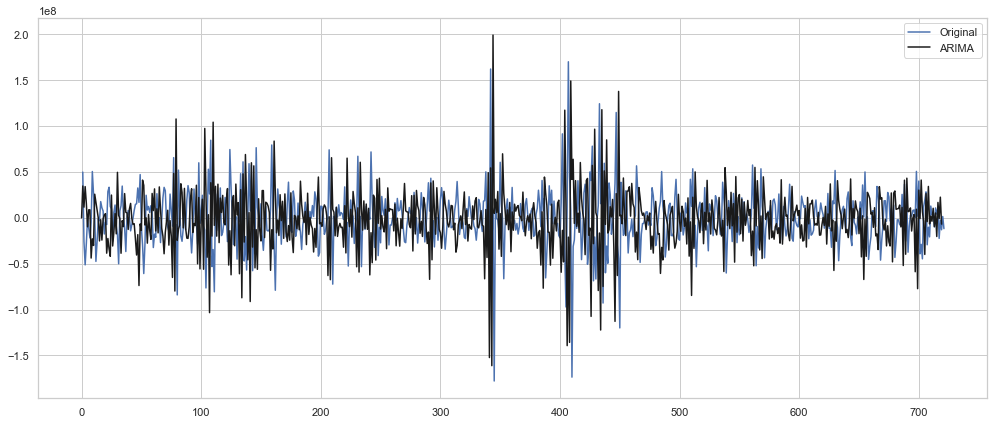

In [611]:
model = statsmodels.tsa.arima_model.ARIMA(ts['СуммаДокумента'].rolling(window=1).mean().values[1:], order=(2, 1, 5))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts['СуммаДокумента'], c='b', label = 'Original')
plt.plot(results_ARIMA.fittedvalues, color='k', label = 'ARIMA')
plt.legend()
plt.show()

*Buyer's account*

In [612]:
def changeAccount(line):
    line = str(line)
    if line[0].isdigit():
        return np.nan
    
    line = line.lower()
    line = line.replace('гпб', 'газпромбанк')
    for i in ['пао ', 'зао ','ооо ', 'оао ','ао ', '\'', '\"']:
        line = line.replace(i,'')
    if 'райффайзен' in line:
        return 'райффайзенбанк'
    elif 'сбер' in line or 'сб ' in line:
        return 'сбербанк'
    elif 'газпромбанк' in line:
        return 'газпромбанк'
    elif 'юникредит' in line:
        return 'юникредит'
    elif 'втб' in line: 
        return 'втб'
    elif 'альфа' in line:
        return 'альфа-банк'
    elif 'промсвязь' in line:
        return 'промсвязьбанк'
    elif 'ситибанк' in line:
        return 'ситибанк'
    elif 'авангард' in line:
        return 'авангард'
    elif 'уралсиб' in line:
        return 'уралсиб'
    elif 'открытие' in line:
        return 'открытие'
    elif 'локо' in line:
        return 'локо-банк'
    elif 'росбанк' in line:
        return 'росбанк'
    elif 'мба' in line:
        return 'мба-москва'
    elif 'гута' in line:
        return 'гута-банк'
    elif 'банк' in line and 'москвы' in line: 
        return 'банк москвы'
    elif 'дойче' in line:
        return 'дойчебанк'
    elif 'россельхозбанк' in line:
        return 'россельхозбанк'
    elif 'мдм' in line:
        return 'мдм банк'
    elif 'александровский' in line:
        return 'банк александровский'
    elif 'отп' in line:
        return 'отп банк'
    elif 'минбанк' in line:
        return 'минбанк'
    elif 'бинбанк' in line:
        return 'бинбанк'    
    else:
        return line
    
data['СчетКонтрагента'] = data['СчетКонтрагента'].apply(changeAccount)        

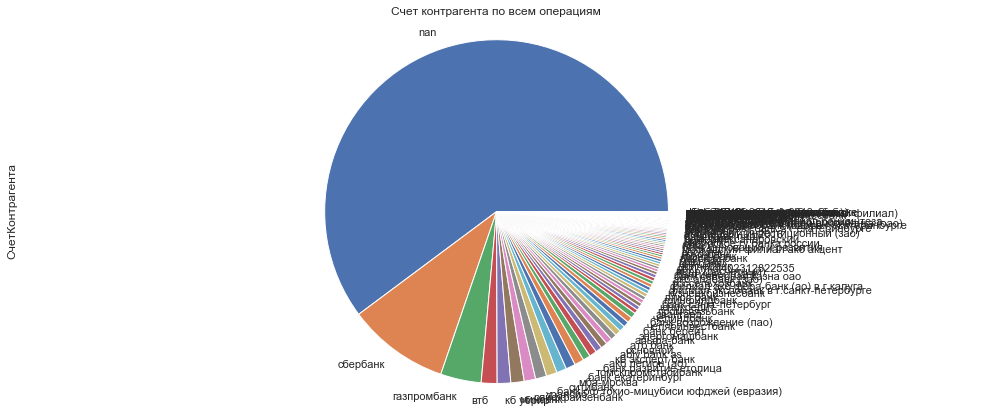

In [613]:
data['СчетКонтрагента'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Счет контрагента по всем операциям')
plt.show()

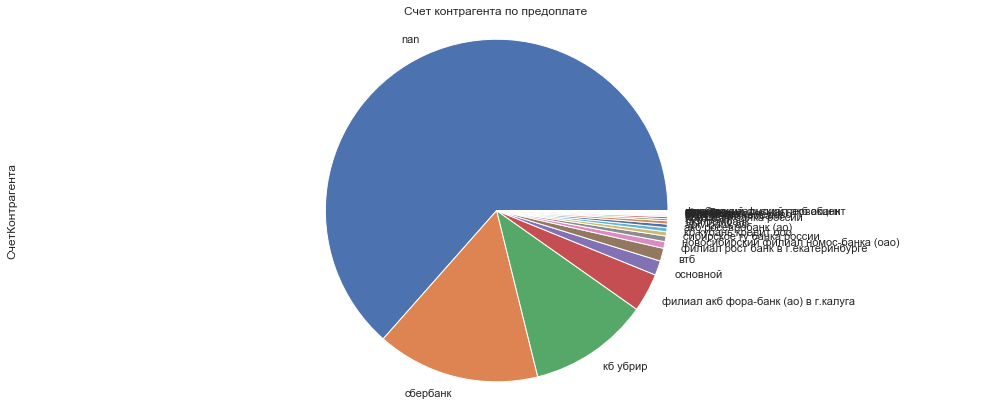

In [614]:
df = data[data['Предоплата']==1]
df['СчетКонтрагента'].value_counts().plot(kind='pie')
plt.title('Счет контрагента по предоплате')
plt.axis('equal')
plt.show()

*Type of transaction*

In [615]:
data['ВидОперации'].value_counts()

Оплата от покупателя                               57737
Оплата поставщику                                   2407
Возврат денежных средств поставщиком                  30
Возврат денежных средств покупателю                   26
Прочие расчеты с контрагентами                         9
Прочее поступление безналичных денежных средств        6
Прочее списание безналичных денежных средств           2
Name: ВидОперации, dtype: int64

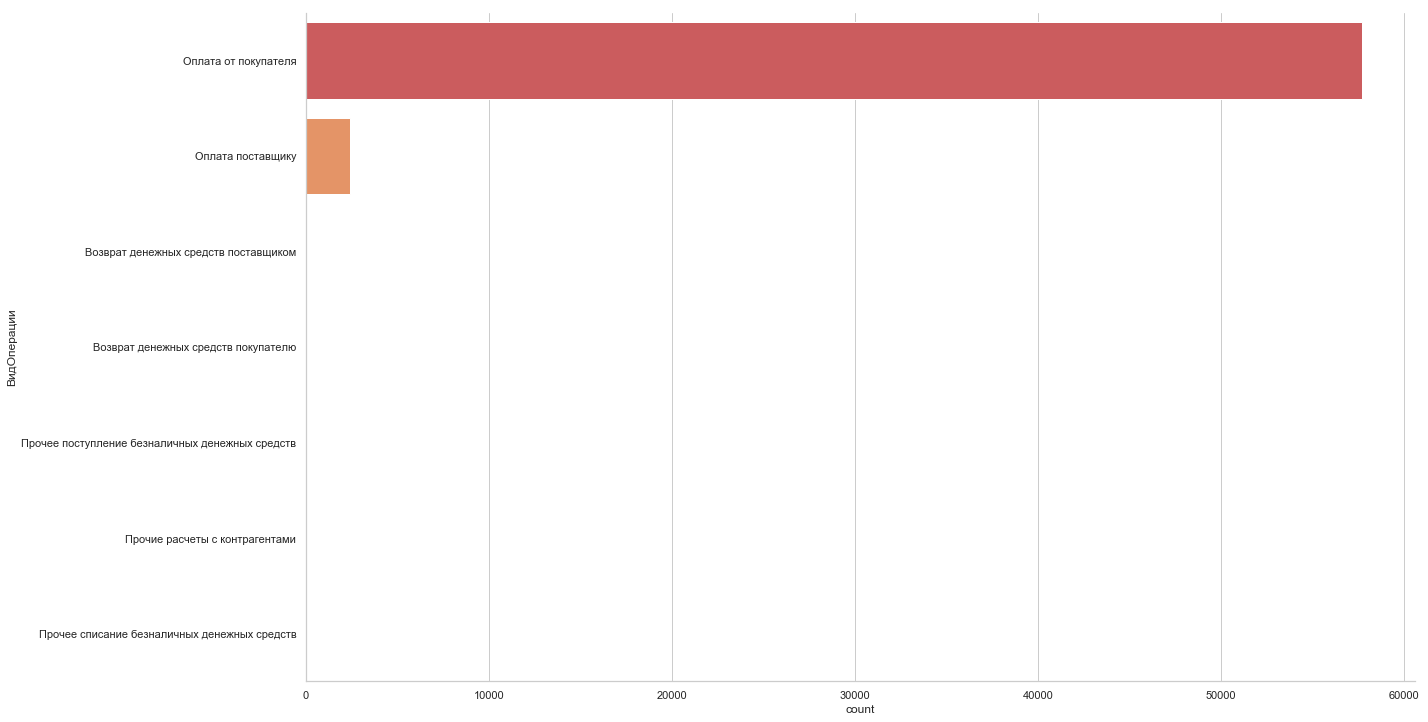

In [616]:
sns.set(style="whitegrid")
sns.catplot(y='ВидОперации', kind="count", palette='Spectral', data=data,  height=10, aspect=6/3)
plt.show()

*Distribution of supplies*

In [617]:
df = data[(data['ДатаНачалаПериодаПоставки']!=0)&(data['ДатаОкончанияПериодаПоставки']!=0)]
df = df[(df['ДатаНачалаПериодаПоставки']!=df['ДатаОкончанияПериодаПоставки'])]

df = df.sort_values(by=['ДатаНачалаПериодаПоставки'])

In [618]:
start = datetime(2011, 6, 22, 0, 0)

x = []
end = []
periods = []
for index, row in df.iterrows():
    if (row['ДатаОкончанияПериодаПоставки']-row['ДатаНачалаПериодаПоставки']).days>=0:
        x.append(row['ДатаНачалаПериодаПоставки'])
        count = 0
        if end !=[] and (row['ДатаНачалаПериодаПоставки']-start).days > min(end):
            while len(end) != 0 and min(end) < (row['ДатаНачалаПериодаПоставки']-start).days: #len(end)!=0 or 
                end.remove(min(end))
                count += 1
            periods.append(periods[-1]+1-count)
        elif end !=[] and (row['ДатаНачалаПериодаПоставки']-start).days <= min(end):
            periods.append(periods[-1]+1-count)
            end.append((row['ДатаОкончанияПериодаПоставки']-start).days)
        elif end == []:
            end.append((row['ДатаОкончанияПериодаПоставки']-start).days)
            periods.append(1)


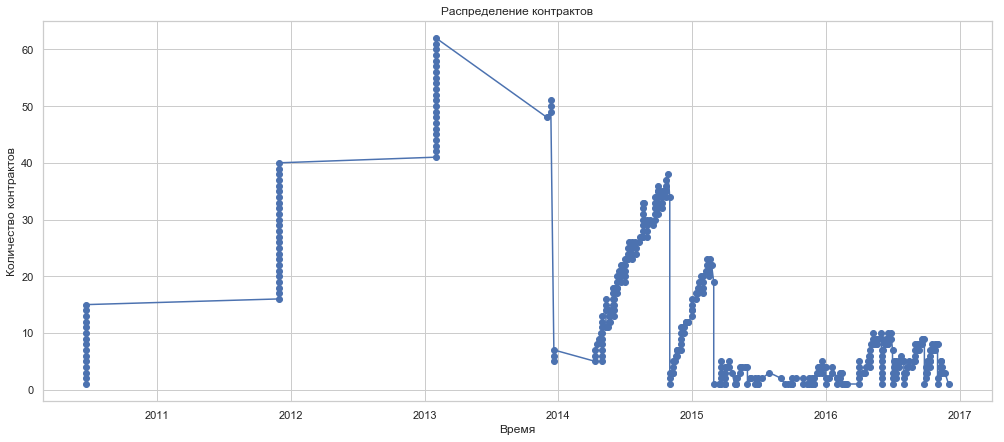

In [619]:
dates = matplotlib.dates.date2num(x)
plt.plot_date(dates, periods,ls = '-')
plt.title('Распределение контрактов')
plt.xlabel('Время')
plt.ylabel('Количество контрактов')
plt.show()

# Update #

## Распределение контрактов во времени

In [621]:
def season(line):
    if line != 0:
        month = line.month
        if month < 3 or month == 12:
            return 0
        elif month in range(3,6):
            return 1
        elif month in range(6,9):
            return 2
        elif month in range(9,12):
            return 3
    return  -1

def month(line):
    if line != 0:
        return line.month
    return -1

def week(line):
    if line != 0:
        first_january = datetime(line.year, 1, 1, 0, 0)
        return (line - first_january).days // 7
    return -1

def supplyLag(row, column1, column2):
    if row[column1] == 0 or row[column2] == 0:
        return -1
    else: 
        return(row[column1]-row[column2]).days

for i in ['ДатаНачалаПериодаПоставки', 'ДатаОкончанияПериодаПоставки', 
          'ПоСчетуОтДаты', 'ПоДоговоруОтДаты','ПоЗапискеОтДаты','ПоПисьмуОтДаты']:
    data[i+' season'] = data[i].apply(season)
    data[i+' month'] = data[i].apply(month)
    data[i+' week'] = data[i].apply(week)

In [623]:
data['Разница между ПоДоговоруОтДаты и ПоСчетуОтДаты'] = 0
data['Разница между ПоДоговоруОтДаты и ПоСчетуОтДаты'] = data.apply(lambda row: supplyLag(row, 'ПоСчетуОтДаты',
                                                                                         'ПоДоговоруОтДаты'), axis=1)

df = data[data['Разница между ПоДоговоруОтДаты и ПоСчетуОтДаты']>=0]

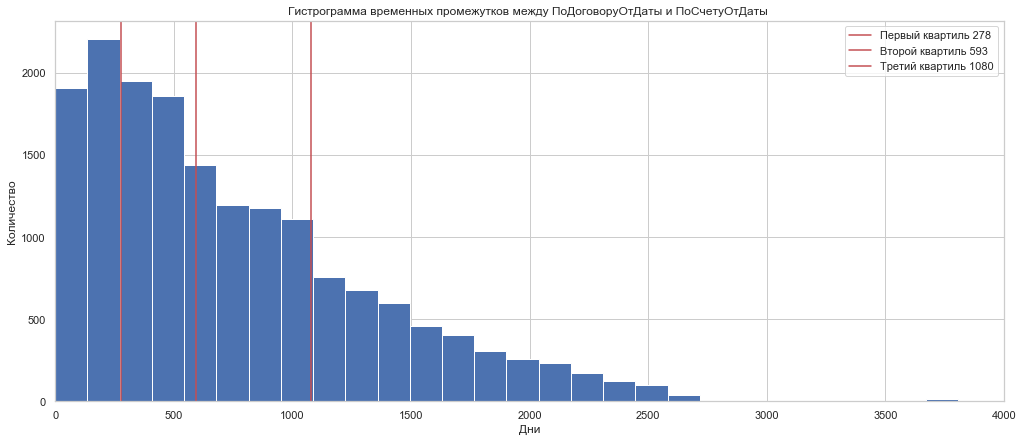

In [624]:
l = df['Разница между ПоДоговоруОтДаты и ПоСчетуОтДаты'].tolist()
l.sort()
plt.hist(df['Разница между ПоДоговоруОтДаты и ПоСчетуОтДаты'], bins = 40)
plt.title('Гистрограмма временных промежутков между ПоДоговоруОтДаты и ПоСчетуОтДаты ')
plt.ylabel('Количество')
plt.xlabel('Дни')
plt.xlim(0,4000)
plt.axvline(x=l[int(0.25*len(l))], c='r', label = 'Первый квартиль %i' % l[int(0.25*len(l))])
plt.axvline(x=np.median(l), c='r', label = 'Второй квартиль %i' % np.median(l))
plt.axvline(x=l[int(0.75*len(l))], c='r', label = 'Третий квартиль %i' % l[int(0.75*len(l))])
plt.legend()
plt.show()

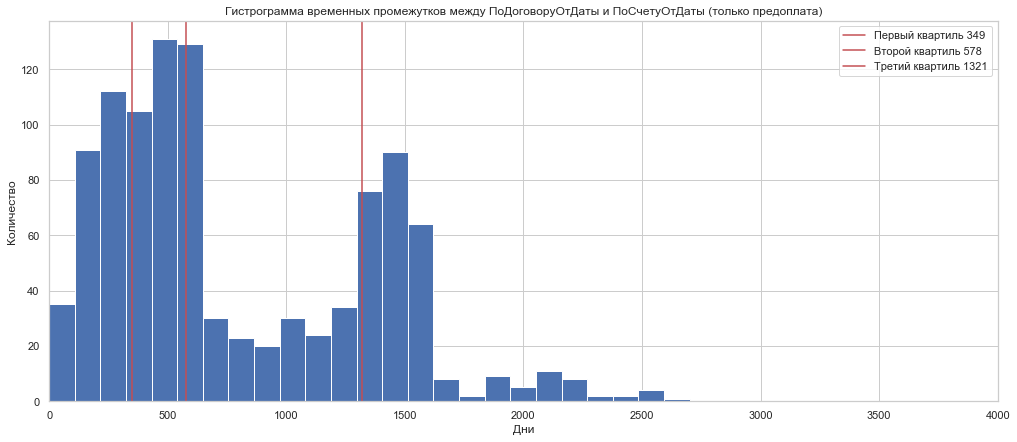

In [625]:
df = df[df['Предоплата']==1]
l = df['Разница между ПоДоговоруОтДаты и ПоСчетуОтДаты'].tolist()
l.sort()
plt.hist(df['Разница между ПоДоговоруОтДаты и ПоСчетуОтДаты'], bins = 40)
plt.title('Гистрограмма временных промежутков между ПоДоговоруОтДаты и ПоСчетуОтДаты (только предоплата)')
plt.ylabel('Количество')
plt.xlabel('Дни')
plt.xlim(0,4000)
plt.axvline(x=l[int(0.25*len(l))], c='r', label = 'Первый квартиль %i' % l[int(0.25*len(l))])
plt.axvline(x=np.median(l), c='r', label = 'Второй квартиль %i' % np.median(l))
plt.axvline(x=l[int(0.75*len(l))], c='r', label = 'Третий квартиль %i' % l[int(0.75*len(l))])
plt.legend()
plt.show()

In [626]:
data['Период поставки'] = 0
data['Период поставки'] = data.apply(lambda row: supplyLag(row, 'ДатаОкончанияПериодаПоставки',
                                                                                         'ДатаНачалаПериодаПоставки'), axis=1)
df = data[data['Период поставки']>=0]

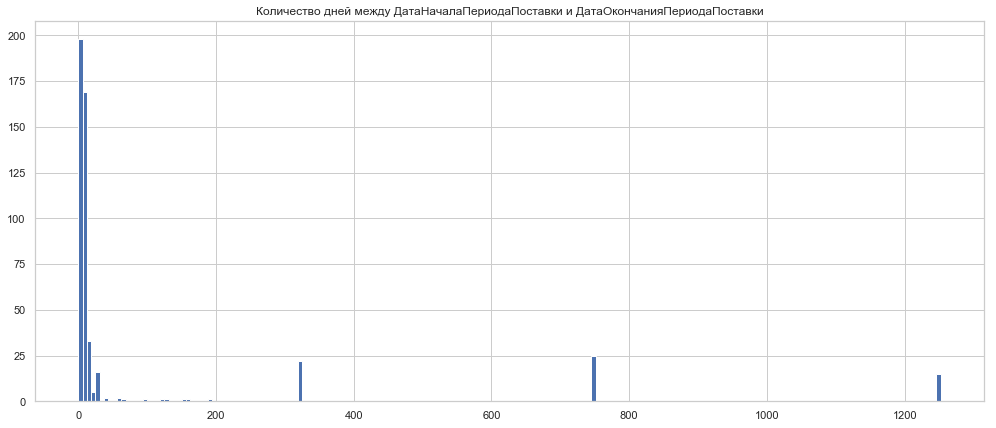

In [627]:
plt.hist(df['Период поставки'], bins = 200)
plt.title('Количество дней между ДатаНачалаПериодаПоставки и ДатаОкончанияПериодаПоставки')
plt.show()

### Распределение контрактов по месяцам ###

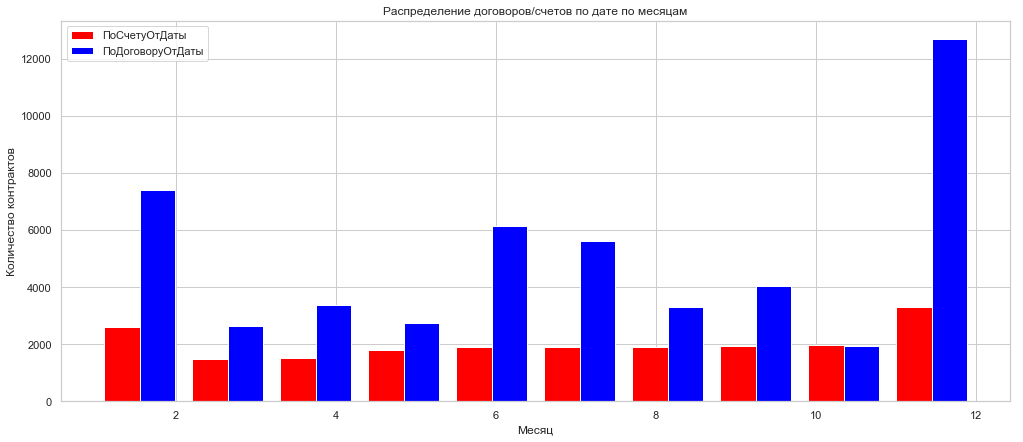

In [628]:
legend = []
score = []
for i in ['ПоСчетуОтДаты', 'ПоДоговоруОтДаты']:
    legend.append(i)
    score.append(list(filter(lambda x: x > -1, data[i+' month'].tolist())))
    
plt.hist(score, color=['red', 'blue'])#'orange', 'green', 
plt.xlabel("Месяц")
plt.ylabel("Количество контрактов")
plt.legend(legend)
plt.title('Распределение договоров/счетов по дате по месяцам')
plt.show()

По графику выше можно сказать:
* параметр ПоСчетуОтДаты распределен более-менее равномерно
* в параметре ПоДоговоруОтДаты выделяются 3 пика - начало/середина/конец года

оба параметра ниже рассмотрены подробнее

### Распределение контрактов по неделям ###

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


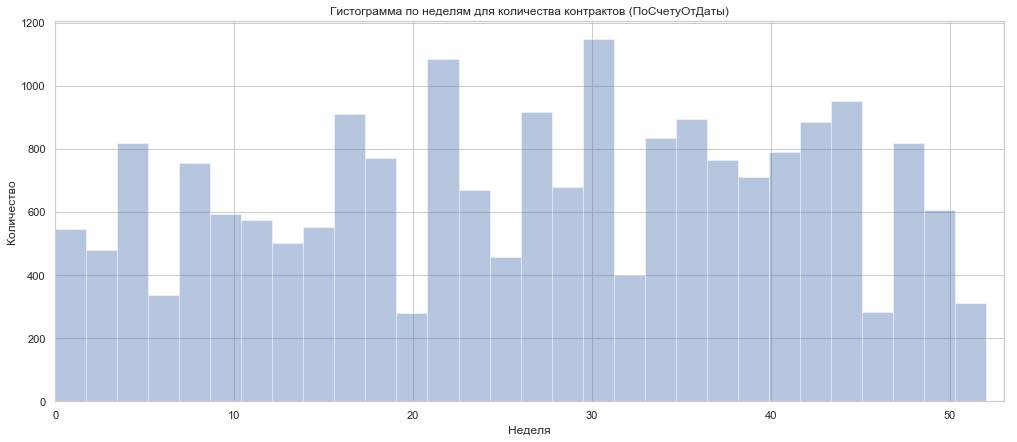

In [629]:
legend = []
score = []
for i in ['ПоСчетуОтДаты', 'ПоДоговоруОтДаты']:
    legend.append(i)
    score.append(list(filter(lambda x: x > -1, data[i+' week'].tolist())))
sns.distplot(score[0], kde=False)
plt.title('Гистограмма по неделям для количества контрактов (ПоСчетуОтДаты)')
plt.xlabel('Неделя')
plt.ylabel('Количество')
plt.xlim(0,53)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


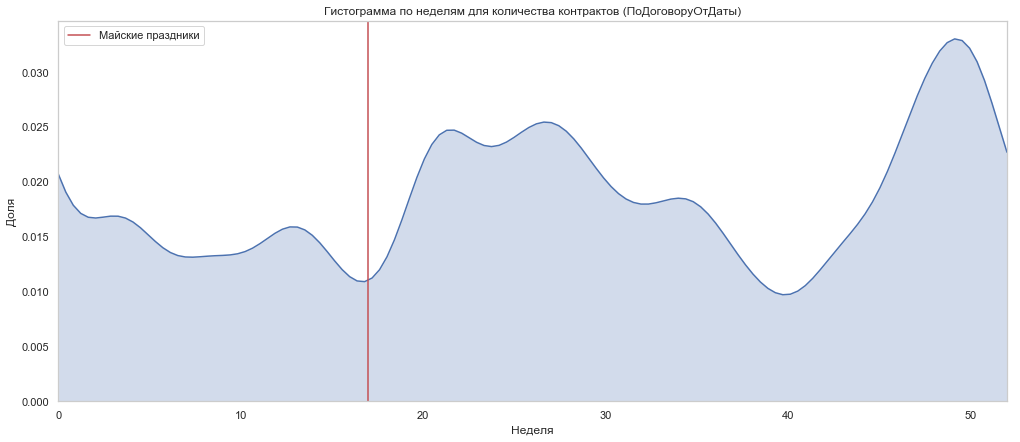

In [630]:
sns.kdeplot(score[1], shade=True, cut=0)
plt.title('Гистограмма по неделям для количества контрактов (ПоДоговоруОтДаты)')
plt.xlim(0,52)
plt.xlabel('Неделя')
plt.ylabel('Доля')
plt.axvline(x=17, c='r', label = 'Майские праздники')
plt.legend()
plt.grid()
plt.show()

## Зависимость суммы контракта от вида сделки

In [631]:
df = pd.DataFrame()

for i in ['ПоСчетуОтДаты', 'ПоДоговоруОтДаты', 'ПоЗапискеОтДаты', 'ПоПисьмуОтДаты']:
    df_local = data.loc[:,['СуммаДокумента',i]]
    df_local = df_local[df_local[i]!=0]
    df_local[i] = i
    df_local.rename(columns={i: 'Вид сделки'}, inplace=True)
    df = df.append(df_local)

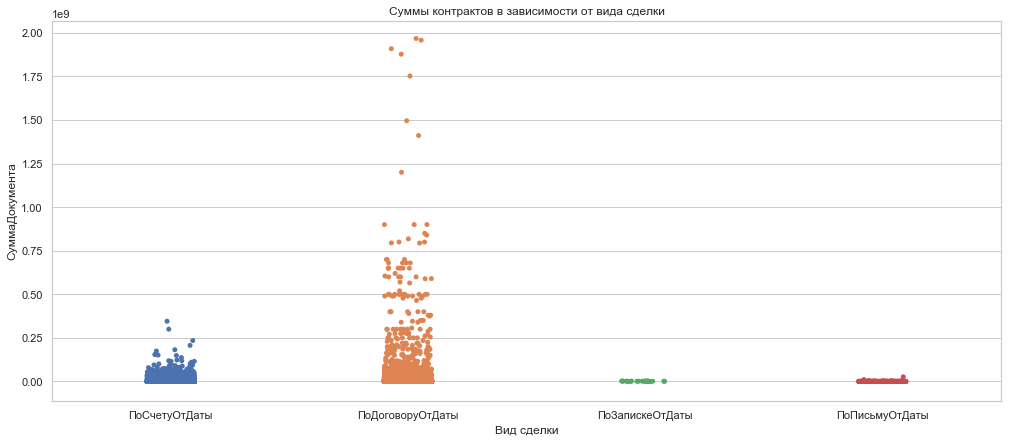

In [632]:
sns.stripplot(x="Вид сделки", y="СуммаДокумента", data=df)
plt.title('Суммы контрактов в зависимости от вида сделки')
plt.rcParams["figure.figsize"] = (12,7)
plt.show()

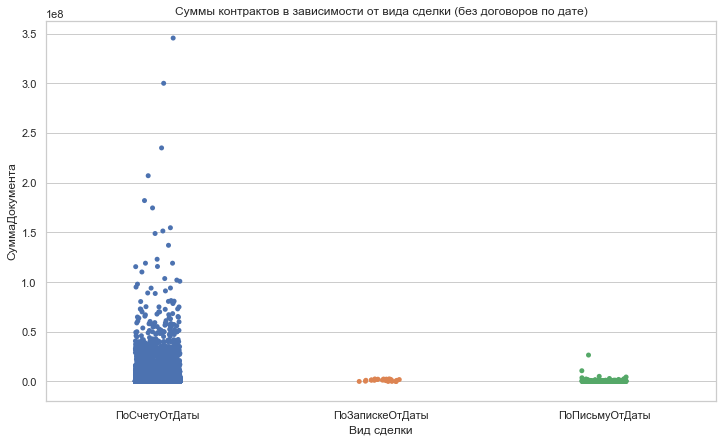

In [633]:
df = df[df['Вид сделки']!='ПоДоговоруОтДаты']
sns.stripplot(x="Вид сделки", y="СуммаДокумента", data=df)
plt.title('Суммы контрактов в зависимости от вида сделки (без договоров по дате)')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


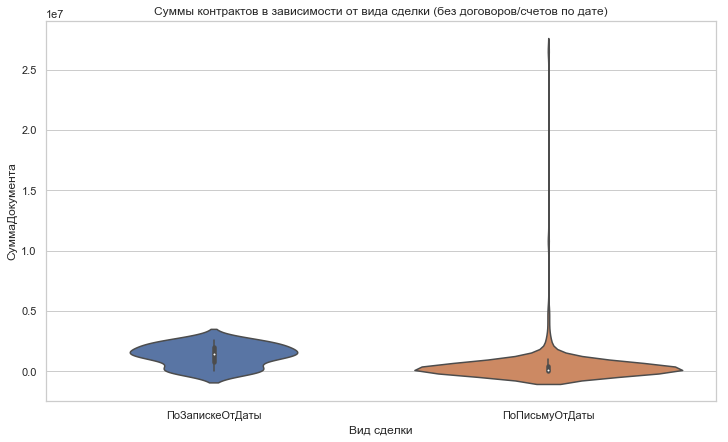

In [634]:
df = df[df['Вид сделки']!='ПоСчетуОтДаты']
sns.violinplot(x="Вид сделки", y="СуммаДокумента", data=df)
plt.title('Суммы контрактов в зависимости от вида сделки (без договоров/счетов по дате)')
plt.show()

## Зависимость между датой заключения сделки и её суммой

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


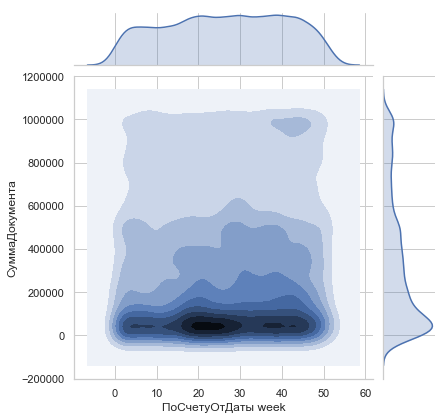

In [635]:
df = data[(data['ПоСчетуОтДаты']!=0)&(data['СуммаДокумента']<=1000000)]
sns.jointplot(x="ПоСчетуОтДаты week", y="СуммаДокумента", data=df, kind="kde")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

По графику выше можно сказать:
* суммы в основной массе сделок не превышают 200000 ₽ 
* количество сделок по неделям распределено равномерно, есть проседания в первые и последние недели года. Очевидно, что это можно объяснить новогодними праздниками
* пятно тёмно-голубого цвета в верхнем правом углу я бы объснил так: в конце года заключаются сделки на длительные промежутки (наверное, на ближайший календарный год)

**Аналогичный график но только по предоплате**

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


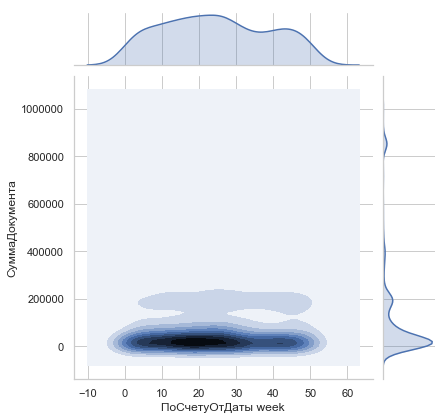

In [636]:
df = data[(data['ПоСчетуОтДаты']!=0)&(data['СуммаДокумента']<=1000000)&(data['Предоплата']==1)]
sns.jointplot(x="ПоСчетуОтДаты week", y="СуммаДокумента", data=df, kind="kde")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [637]:
df[data['СуммаДокумента']>200000].shape[0]/df.shape[0]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.13526119402985073

По графику выше можно сказать, что лишь в 13% cлучаев предоплата превышает 200 000 ₽

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


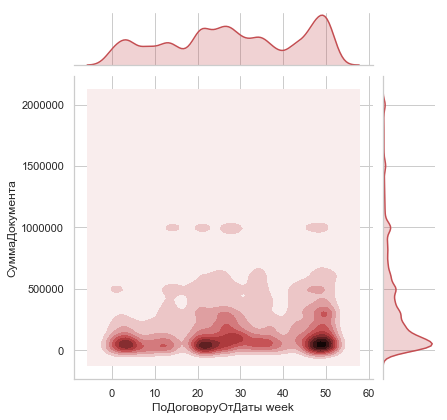

In [638]:
df = data[(data['ПоДоговоруОтДаты']!=0)&(data['СуммаДокумента']<=2000000)]
sns.jointplot(x="ПоДоговоруОтДаты week", y="СуммаДокумента", data=df, kind="kde",color='r')
plt.show()

По графику выше можно сказать:
* выделяются два пика заключений контрактов - середина года (20-30 неделя) и начало+конец года
* два пика из предыдущего пункта хорошо видны и в разрезе суммы контрактов - 3 тёмных пятна

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


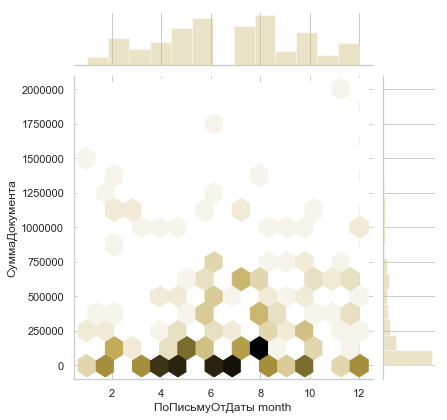

In [639]:
df = data[(data['ПоПисьмуОтДаты']!=0)&(data['СуммаДокумента']<=2000000)]
sns.jointplot(x="ПоПисьмуОтДаты month", y="СуммаДокумента", data=df, kind="hex",color='y')
plt.show()